In [1]:
import mygene
import numpy as np
import pandas as pd
import os
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [3]:
nean_data_dir = "./neanderthal_introgressed/"
allen_data_dir = "./alleninf/alleninf/data/"
donor_data_dir = "./donor_data/"

CLOBBER = False
MNI_corr = pd.read_csv(os.path.join(allen_data_dir,"corrected_mni_coordinates.csv"),header=0,index_col=0)
# see NOTES.txt for a description of contents, note that CIs may need to be incorporated but the "per_genene"
# file gives us a place to start
nn_CB_per_gene = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_gene.txt"),sep="\t",header=0)
nn_CB_per_snp  = pd.read_csv(os.path.join(nean_data_dir,"ase_cerebellum.per_snp.txt"),sep="\t",header=0)

out_ensembl2gene = "ase_cerebellum_ensembl2gene.csv"

In [4]:
MNI_corr.head()

,corrected_mni_x,corrected_mni_y,corrected_mni_z
well_id,,,
126439333,-13.467693,2.255686,3.432523
126432538,-53.603259,-8.120055,0.868643
126435762,-16.288739,-34.198856,-19.944686
126439285,-17.820212,3.595613,-32.872868
126435744,-23.726456,-25.139000,-16.692841


In [5]:
nn_CB_per_snp.head()

,chrom,pos,geneid,est.mean,sd.sd,ci0.005,ci0.025,ci0.975,ci0.995,REF,ALT,RSID,ANCESTRAL,GLOBAL_AF,EAS_AF,EUR_AF,est.scaled,est.scaled.polarized
0,1,3551792,ENSG00000116213,-0.117100,0.019119,-0.166485,-0.154656,-0.079607,-0.067841,G,A,rs2296034,G,0.078674,0.1915,0.0388,-0.120094,-0.120094
1,1,10220149,ENSG00000130939,0.559621,0.626792,-0.962172,-0.617283,1.848444,2.294328,T,G,rs77148178,T,0.006190,0.0000,0.0219,1.763459,1.763459
2,1,10221136,ENSG00000130939,-1.386307,0.790525,-3.718340,-3.090941,0.013753,0.390911,G,C,rs114631287,G,0.006190,0.0000,0.0219,-3.652746,-3.652746
3,1,10334544,ENSG00000054523,-0.080021,0.400384,-1.120116,-0.869507,0.702521,0.946659,C,T,rs115415660,C,0.006589,0.0000,0.0229,-0.016892,-0.016892
4,1,10363664,ENSG00000054523,-0.040922,0.043353,-0.153018,-0.126138,0.044048,0.070686,G,T,rs41274458,G,0.006589,0.0000,0.0229,0.091934,0.091934


In [6]:
nn_CB_per_gene.head()

,geneid,est.scaled.polarized.mean
0,ENSG00000000457,0.527106
1,ENSG00000002746,-0.887026
2,ENSG00000003249,-0.594831
3,ENSG00000003987,0.451745
4,ENSG00000004799,0.137427


In [7]:
## extract gene names and additional information about the gene from the ensemble ID
genes = nn_CB_per_gene['geneid'] #these are the ensemble gene ids, called "ensembl.gene" in mygene
fields = "alias,summary,symbol,name,taxid,entrezgene,ensembl.gene"
if not os.path.isfile(out_ensembl2gene) or CLOBBER == True:
    mg = mygene.MyGeneInfo()
    df_genes = mg.querymany(list(genes),species="human",
                            fields=fields,
                            as_dataframe=True,
                            email="christopher.steele@mail.mcgill.ca")
    df_genes.to_csv(out_ensembl2gene)
else:
    df_genes = pd.read_csv(out_ensembl2gene)

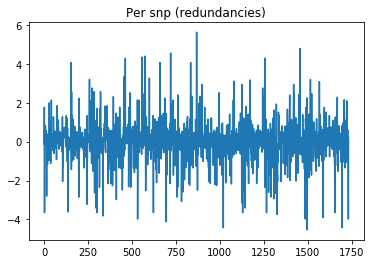

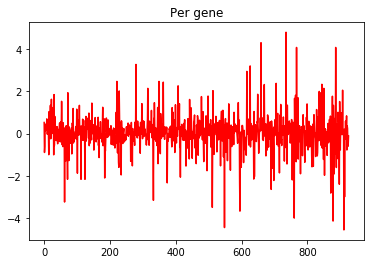

In [8]:
plt.plot(nn_CB_per_snp['est.scaled.polarized'])
plt.title('Per snp (redundancies)')
#plt.bar(np.arange(nn_CB_per_snp.shape[0]),nn_CB_per_snp['est.scaled.polarized'])
plt.figure()
plt.plot(nn_CB_per_gene['est.scaled.polarized.mean'],'r')
plt.title('Per gene')

In [9]:
## merge the df_genes with our neanderthal data
df_gene_nn = pd.merge(df_genes,nn_CB_per_gene,left_on="query",right_on="geneid")


In [111]:
## work with the code that K. Gorgolewski wrote
# reads allen database donor data (whatever is in the dir)
def read_donor_data(data_dir):
    from glob import glob
    donor_ids = [path.split(os.path.sep)[-2] for path in glob(os.path.join(data_dir, "*", "MicroarrayExpression.csv"))]
    print "Data directory contains the following donors: %s" % ", ".join(donor_ids)
    main_df = "empty"
    for donor_id in donor_ids:
        print "Reading data from donor %s"%donor_id
        sample_locations = pd.read_csv(os.path.join(data_dir, donor_id, 'SampleAnnot.csv'))
        df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"]) #column of donor_id
        df_well_ids = sample_locations[['well_id',"slab_type"]] #keep slab type so that we can filter on it
        df = pd.concat([df,df_well_ids],axis=1,ignore_index=False)
        expression_data = pd.read_csv(os.path.join(data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
        expression_data.columns = range(expression_data.shape[1])
        df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)
        if isinstance(main_df, str):
            main_df = df
        else:
            main_df = pd.concat([main_df, df], ignore_index=True)
    return main_df #now formatted by row,col sample_well_id,probe_id

In [112]:
df_donors = read_donor_data(donor_data_dir)


Data directory contains the following donors: H0351.2001
Reading data from donor H0351.2001


In [128]:
df_donors[df_donors['slab_type']=='CB'].shape

(53, 58695)

In [127]:
#probes are the same for ALL donors, same file (checked with diff)
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0,index_col=0) #setting index_col lets us lookup by probe_id
print(df_probes.loc[1058685].gene_symbol)
df_probes.shape

C8G


(58692, 6)

In [101]:
## XXX testing
donor_id = "H0351.2001"
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0) #this has the well_id colum
df = pd.DataFrame([donor_id] * sample_locations.shape[0], columns=["donor_id"])
expression_data = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'MicroarrayExpression.csv'), header=None, index_col=0)
expression_data.columns = range(expression_data.shape[1])
df = pd.concat([df, expression_data.T], axis=1, ignore_index=False)

In [102]:
sample_locations = pd.read_csv(os.path.join(donor_data_dir, donor_id, 'SampleAnnot.csv'),header=0)

In [103]:
CB_well_ids = sample_locations[sample_locations['slab_type']=="CB"]['well_id']

In [104]:
df_probes = pd.read_csv(os.path.join(donor_data_dir,donor_id,'Probes.csv'),header=0)


In [85]:
df_probes

,probe_id,probe_name,gene_id,gene_symbol,gene_name,entrez_id,chromosome
0,1058685,A_23_P20713,729,C8G,"complement component 8, gamma polypeptide",733.0,9
1,1058684,CUST_15185_PI416261804,731,C9,complement component 9,735.0,5
2,1058683,A_32_P203917,731,C9,complement component 9,735.0,5
3,1058682,A_23_P138819,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
4,1058681,A_24_P232500,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
5,1058680,A_24_P201491,736,MRPL49,mitochondrial ribosomal protein L49,740.0,11
6,1058679,CUST_1334_PI416261804,737,ZNHIT2,"zinc finger, HIT-type containing 2",741.0,11
7,1058678,A_23_P329286,737,ZNHIT2,"zinc finger, HIT-type containing 2",741.0,11
8,1058677,A_23_P52888,740,MPPED2,metallophosphoesterase domain containing 2,744.0,11
9,1058676,CUST_6483_PI416261804,741,C11orf9,chromosome 11 open reading frame 9,745.0,11
